In [1]:
from openai import OpenAI
import dotenv
import os
import json

# for temporal evaluation
from functools import wraps
from time import time
from datetime import datetime

dotenv.load_dotenv("../.env")

True

In [2]:
# logging setup
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
# decorator to measure execution time of functions
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r took: %2.4f sec' % \
          (f.__name__, args, kw, te-ts))
        return result
    return wrap

In [4]:
# initialize OpenAI client
CLIENT = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("DENIS_KEY")
)

In [26]:
# dataset reduction procedures
def duplicate_lines_remover(csv_listed_dataset):
    """
    Remove duplicate subsequent equal lines from the CSV data.
    """
    csv_text_clean = [csv_listed_dataset[0]]
    starting_len = len(csv_listed_dataset[1:])
    for line in csv_listed_dataset[1:]:
        if csv_text_clean[-1] != line:
            csv_text_clean.append(line)
    print(
        f"Deduplication: reduced size from {starting_len} to {len(csv_text_clean) - 1}.")
    return csv_text_clean


def reduce_size(csv_listed_dataset, remove_one_every_n=2, times=1):
    """
    Reduce the size of the dataset by removing one row every n rows.
    """
    clean_data = [csv_listed_dataset[0]]
    starting_len = len(csv_listed_dataset[1:])
    for i in range(1, starting_len + 1):
        if i % remove_one_every_n == 0:
            continue
        clean_data.append(csv_listed_dataset[i])
    print(f"Remove one every {remove_one_every_n}: reduced size from {starting_len} to {len(clean_data) - 1}.")
    return clean_data


def header_anonymizer(csv_listed_dataset):
    """
    Anonymize the header of the CSV data, substituing register names with letters.
    """
    # Header anonymization
    old_header = csv_listed_dataset[0].split(",")
    new_header = ",".join([chr(ord('A') + i) for i in range(len(old_header))])
    anonymized_header_csv_listed_dataset = [c for c in csv_listed_dataset]
    anonymized_header_csv_listed_dataset[0] = new_header

    # reference mapping (letter, original register name)
    ref = {chr(ord('A') + i): old_header[i] for i in range(len(old_header))}
    
    return (anonymized_header_csv_listed_dataset, ref)


# dataset selection
TESTED_DATASET = "plc_data_log_20251128_212142"

# dataset reading
with open(f"../datasets/{TESTED_DATASET}.csv", "r") as f:
    csv_text = f.read()
    
# csv file in which every line is an element of a list (header included)
csv_listed_dataset = csv_text.split("\n")

# deduplication
to_analyze = duplicate_lines_remover(csv_listed_dataset)
# size reduction
to_analyze = reduce_size(to_analyze)
to_analyze = reduce_size(to_analyze)
to_analyze = reduce_size(to_analyze)
#to_analyze = reduce_size(to_analyze)

# header anonymization
anonymized_to_analyze, reference_mapping = header_anonymizer(to_analyze)

# final dataset size and name
compressed_dataset_size = len(to_analyze) - 1
tested_dataset_name = f"{TESTED_DATASET}_compressed_{compressed_dataset_size}_rows.csv"

text_data = "\n".join(to_analyze)
anonymized_text_data = "\n".join(anonymized_to_analyze)

Deduplication: reduced size from 6001 to 6001.
Remove one every 2: reduced size from 6001 to 3001.
Remove one every 2: reduced size from 3001 to 1501.
Remove one every 2: reduced size from 1501 to 751.


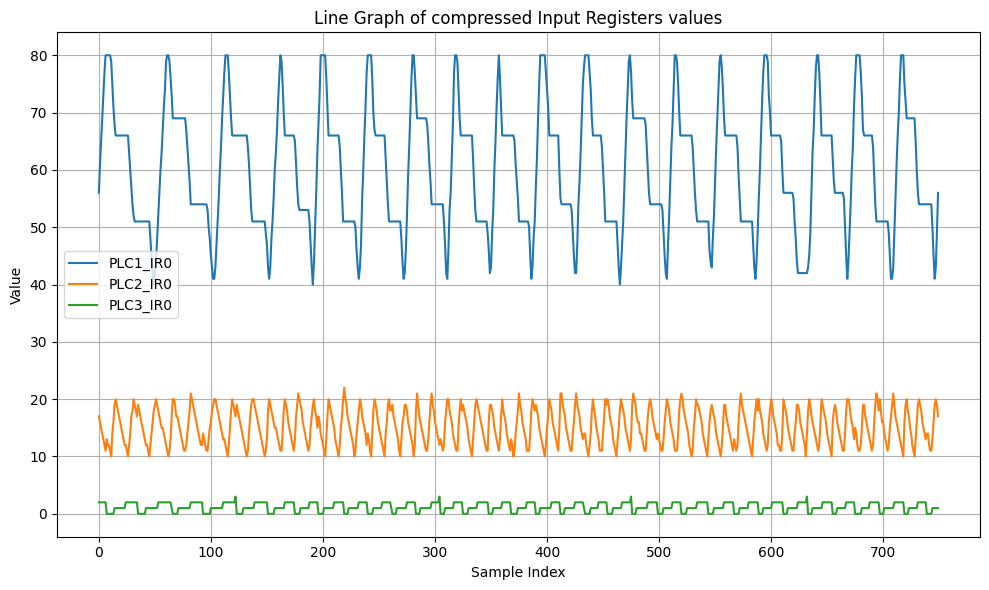

In [23]:
# compressed data visualization
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# Load dataframe
df = pd.read_csv(StringIO(text_data))

# Select columns (1, 4, 10) → (0, 3, 9)
cols = [df.columns[1], df.columns[5], df.columns[7]]

# Plot line graph
plt.figure(figsize=(10, 6))
for col in cols:
    plt.plot(df[col], label=col)

plt.title("Line Graph of compressed Input Registers values")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
class LogErrorCode():
    MODEL_ERROR = 101
    JSON_PARSE_ERROR = 201
    MISSING_SHORT_ANSWER = 301
    
    message = ""
    
    def __init__(self, code):
        self.code = code
        if code == self.MODEL_ERROR:
            self.message = "Model returned an error."
        elif code == self.JSON_PARSE_ERROR:
            self.message = "Error parsing JSON response."
        elif code == self.MISSING_SHORT_ANSWER:
            self.message = "Missing short answer in response."
    
    def __str__(self):
        return f"[Error {self.code}]: {self.message}"

In [29]:
possible_ics_types = [
    "Power Generation Plant",
    "Manufacturing Assembly Line",
    "Oil and Gas Refinery",
    "Water Purification Plant",
    "Nuclear Power Plant",
    "Not Identifiable"
]
correct_answer_index = 3 # Water Purification Plant

question = f"Q1.1: Infer, based on data provided, what type of phisical Industrial Control System (ICS) between the following options: {possible_ics_types}"

prompt = """
You are an expert in Industrial Control Systems (ICS), specialized in identifying system architecture and component relationships by analyzing time-series values of PLC registers.

## Data Format
You will receive a raw plaintext dataset in CSV form:
- The first row contains column names (register labels).
- All fields are comma-separated.
- Each following row represents the register states at a specific timestamp.

## Task
Analyze the dataset and answer the following question:
- {question}

## Data (CSV)""".format(question=question)

In [9]:
def send_prompt(model_name, prompt, data):
    try:
        c = CLIENT.chat.completions.create(
            model=model_name,
            messages=[
                {
                    "role": "system",
                    "content": [{"type": "text", "text": prompt}]
                },
                {
                    "role": "user",
                    "content": [{"type": "text", "text": data}]
                },
            ],
            response_format={
                "type": "json_schema",
                "json_schema": {
                    "name": "response",
                    "strict": True,
                    "schema": {
                        "type": "object",
                        "properties": {
                            "response": {
                                "type": "object",
                                "properties": {
                                    "short_answer": {
                                        "enum": possible_ics_types
                                    },
                                    "confidence": {
                                        "type": "number",
                                        "description": "Confidence level from 0 to 1, where 1 is highest"
                                    },
                                    "reasoning": {
                                        "type": "string",
                                        "description": "Reasoning behind the answer"
                                    }
                                },
                                "required": ["short_answer", "confidence", "reasoning"]
                            },
                            "limitations": {
                                "type": "array",
                                "description": "List of limitations or uncertainties in the analysis"
                            },
                            "internal_checks": {
                                "type": "object",
                                "properties": {
                                    "columns_used": {
                                        "type": "array",
                                        "description": "List of columns from the dataset that were used in the analysis"
                                    },
                                    "assumptions_detected": {
                                        "type": "array",
                                        "description": "List of assumptions made during the analysis"
                                    },
                                    "warnings": {
                                        "type": "array",
                                        "description": "List of warnings or potential issues identified during the analysis"
                                    }
                                },
                                "required": ["columns_used", "assumptions_detected", "warnings"]
                            }
                        },
                        "required": ["response", "limitations", "internal_checks"],
                        "additionalProperties": False
                    }
                }
            }
        )

        raw = c.choices[0].message.content
        if not raw:
            raise Exception("No content in response")
        return raw
    
    except Exception as e:
        return e

In [10]:
def evaluate_models(models, prompt, csv_data, repetitions=10):
    '''
    Evalute accuracy of multiple models on the given prompt and data.
    '''
    models_log = []
    
    for model in models:
        logging.info(f"Evaluating model: {model}")
        
        correct_answers_counter = 0
        errors_counter = 0
        
        tests_log = []
        
        model_log = {
            "model": model,
            "valid_tests_number": 0,
            "correct_answers_counter": 0,
            "wrong_answers_counter": 0,
            "errors_counter": 0,
            "accuracy": 0.0,
            "tests": [],
            "model_evaluation_time": 0.0
        }
        
        model_start_time = time()
        for i in range(repetitions):
            logging.info(f"Test {i+1}/{repetitions} for model {model}")
            test_log = {"run": i, "short_answer": None, "confidence": None, "error_code": None}
                        
            # send prompt to model and get response
            response = send_prompt(model, prompt, csv_data)
            
            # check if there was a model error
            if isinstance(response, Exception):
                errors_counter += 1
                test_log["error_code"] = LogErrorCode.MODEL_ERROR
                logging.error(f"Model error for {model} on test {i+1}: {response}")
                tests_log.append(test_log)
                continue
            
            # parse JSON response
            try:
                json_response = json.loads(response)
                response_data = json_response.get('response', {})
                
                short_answer = response_data.get('short_answer', '').strip()
                confidence = response_data.get('confidence', 0)
                
                # check missing short answer
                if not short_answer:
                    errors_counter += 1
                    test_log["error_code"] = LogErrorCode.MISSING_SHORT_ANSWER
                    logging.error(f"Missing short answer for {model} on test {i+1}")
                    tests_log.append(test_log)
                    continue
                
                # correct answer check
                if short_answer.lower() == possible_ics_types[correct_answer_index].strip().lower():
                    correct_answers_counter += 1
                
                # update log
                test_log["short_answer"] = short_answer
                test_log["confidence"] = confidence
                    
            except (TypeError, json.JSONDecodeError) as e:
                errors_counter += 1
                test_log["error_code"] = LogErrorCode.JSON_PARSE_ERROR
                logging.error(f"JSON parse error for {model} on test {i+1}: {e}")
                tests_log.append(test_log)
                continue
            
            # in the end of each test, append the test log
            tests_log.append(test_log)
            logging.info(f"Test {i+1} for model {model} ended without errors!")
            
        model_end_time = time()
            
        # update model log
        valid_tests_number = repetitions - errors_counter
        model_log["valid_tests_number"] = valid_tests_number
        model_log["correct_answers_counter"] = correct_answers_counter
        model_log["wrong_answers_counter"] = valid_tests_number - correct_answers_counter
        model_log["errors_counter"] = errors_counter
        model_log["accuracy"] = (correct_answers_counter / valid_tests_number) * 100.0 if valid_tests_number > 0 else 0.0
        model_log["tests"] = tests_log
        model_log["model_evaluation_time"] = round(model_end_time - model_start_time, 1)
        
        # in the end of each model evaluation, append the model log
        models_log.append(model_log)
    
    return models_log
    

In [11]:
# tested models
models = [
    "x-ai/grok-4.1-fast:free",
    #"openai/gpt-oss-20b:free",
    #"meta-llama/llama-3.3-70b-instruct:free",
    #"nvidia/nemotron-nano-12b-v2-vl:free",
    "tngtech/deepseek-r1t2-chimera:free",
    #"mistralai/mistral-small-3.1-24b-instruct:free",
    #"openrouter/bert-nebulon-alpha",
    #"z-ai/glm-4.5-air:free"
]

In [27]:
start_date = datetime.today().strftime('%Y_%m_%d')
start_hour = datetime.now().strftime('%H_%M_%S')
start = time()

repetitions = 10
# simple switch for anonymized dataset evaluation
anon = True
if anon:
    models_log = evaluate_models(models, prompt, anonymized_text_data, repetitions)
else:
    models_log = evaluate_models(models, prompt, text_data, repetitions)

end = time()

evaluation_time = end - start

evaluation = {
    "question": question,
    "tested_models": models,
    "tested_dataset_name": tested_dataset_name,
    "dataset_header_anonymization": anon,
    "total_evaluation_time": round(evaluation_time, 1),
    "models_log": models_log,
}

dir_responses_path = f"../responses/{start_date}/"
os.makedirs(os.path.dirname(dir_responses_path), exist_ok=True)
with open(f"{dir_responses_path}/{start_date}-{start_hour}_models_evaluation.json", "w") as f:
    json.dump(evaluation, f, indent=4)

INFO:root:Evaluating model: x-ai/grok-4.1-fast:free
INFO:root:Test 1/10 for model x-ai/grok-4.1-fast:free


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.449891 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.929723 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
ERROR:root:Model error for x-ai/grok-4.1-fast:free on test 1: Error code: 429 - {'error': {'message': 'Provider returned error', 'code': 429, 'metadata': {'raw': 'x-ai/grok-4.1-fast:free is temporarily rate-limited upstream. Please retry shortly, or add your own key to accumulate your rate limits: https://openrouter.ai/settings/integrations', 'provider_name': 'xAI'}}, 'user_id': 'user_2vUxAubGLTwbrRqcWrkOqYjC47M'}
INFO:root:Test 2/10 for model x-ai/grok-4.1-fast:free
INFO:httpx:HTTP Request: POST https